In [84]:
#import libraries
import numpy as np
import pandas as pd
import time
import math
import re

import sklearn.model_selection
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from textwrap import wrap
import seaborn as sns

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
!pip install transformers

In [87]:
### required to run attention, Transformer block and embedding layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
## Implement multi head self attention as a Keras layer.
"""


class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


"""
## Implement a Transformer block as a layer
"""


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


"""
## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).
"""


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [88]:
!python("/content/drive/MyDrive/Colab Notebooks/peptide ml detection/scripts/transformers.py")

/bin/bash: -c: line 1: syntax error near unexpected token `"/content/drive/MyDrive/Colab Notebooks/peptide ml detection/scripts/transformers.py"'
/bin/bash: -c: line 1: `python("/content/drive/MyDrive/Colab Notebooks/peptide ml detection/scripts/transformers.py")'


In [89]:
# !python("/content/drive/MyDrive/Colab Notebooks/peptide detection/data/transformers.py")
# from transformers import TokenAndPositionEmbedding, TransformerBlock

In [90]:
# import detected and undetected datasets
detected_peptides = pd.read_table('/content/drive/MyDrive/Colab Notebooks/peptide ml detection/data/detected_peptides_all_nsaf_aaindex1.tsv')
undetected_peptides = pd.read_table('/content/drive/MyDrive/Colab Notebooks/peptide ml detection/data/undetected_peptides_all_nsaf_aaindex1.tsv')

In [91]:
#keep detected and undetected peptides less than or equal to 40 aa AND greater than or equal to 7 aa in length
detected_peptides = detected_peptides.loc[(detected_peptides["Peptide"].str.len()>=7) &
                                          (detected_peptides["Peptide"].str.len()<=40)].reset_index(drop=True)

undetected_peptides = undetected_peptides.loc[(undetected_peptides["Peptide"].str.len()>=7) &
                                              (undetected_peptides["Peptide"].str.len()<=40)].reset_index(drop=True)

In [92]:
print(detected_peptides.shape)
print(undetected_peptides.shape)

(1916, 571)
(5742, 571)


In [93]:
# double check 0 peptides in undetected peptides are present in detected peptides
len(undetected_peptides[undetected_peptides["Peptide"].isin(detected_peptides["Peptide"])])

0

In [94]:
#drop unnecessary columns
detected_peptides = detected_peptides.drop(['Protein', 'PEP', 'Protein_length'], axis=1)
undetected_peptides = undetected_peptides.drop(['Protein', 'PEP', 'Protein_length'], axis=1)

In [95]:
print(detected_peptides.shape)
print(undetected_peptides.shape)

(1916, 568)
(5742, 568)


In [96]:
#add detectability column
detected_peptides.insert(loc=1, column='Detectability', value=1)
undetected_peptides.insert(loc=1, column='Detectability', value=0)

In [97]:
print(detected_peptides.shape)
print(undetected_peptides.shape)

(1916, 569)
(5742, 569)


In [98]:
detected_peptides.head()

,Peptide,Detectability,NSAF,ANDN920101,ARGP820101,ARGP820102,ARGP820103,BEGF750101,BEGF750102,BEGF750103,...,KARS160113,KARS160114,KARS160115,KARS160116,KARS160117,KARS160118,KARS160119,KARS160120,KARS160121,KARS160122
0,YYDSRPGGYGYGYGR,1,0.044586,4.354000,0.894000,0.438667,0.607333,0.389333,0.706000,0.900667,...,10.866667,17.401200,11.800000,23.200000,32.333333,5.248667,19.705333,-0.320000,8.734067,2.490933
1,NNTVGLIQLNRPK,1,0.100000,4.335385,0.815385,0.980769,0.990769,0.539231,0.714615,0.740769,...,10.769231,16.293154,12.153846,19.307692,30.156000,5.874615,23.903000,-0.465154,9.510308,3.847692
2,DKLNNLVLFDK,1,NaN,4.441818,1.024545,1.219091,1.189091,0.654545,0.722727,0.715455,...,12.000000,17.759091,13.454545,21.090909,33.638273,6.285455,25.838000,-0.032545,10.084909,2.913364
3,NMEINKEELLGTK,1,0.021672,4.324615,0.800769,0.986154,1.042308,0.662308,0.688462,0.678462,...,11.153846,18.069231,13.000000,22.153846,32.616462,6.188462,24.933308,-0.478923,9.787308,2.497308
4,NLYHNLCTSLFPTIHGNDEVKR,1,0.051157,4.419545,0.879545,1.004091,0.995909,0.537727,0.731818,0.741818,...,11.272727,17.421545,12.863636,21.409091,33.274000,6.046364,24.583818,-0.668273,9.901045,3.677727


In [99]:
# remove nan values
all_peptides = pd.concat([detected_peptides, undetected_peptides])
print(all_peptides.shape)
all_peptides = all_peptides.dropna(axis=1, how='any')
print(all_peptides.shape)

detected_peptides = all_peptides[all_peptides['Detectability'] == 1]
undetected_peptides = all_peptides[all_peptides['Detectability'] == 0]
print(detected_peptides.shape)
print(undetected_peptides.shape)

(7658, 569)
(7658, 555)
(1916, 555)
(5742, 555)


In [100]:
# take random sample of undetected_peptides, with equal number of rows to detected_peptides
# random_state is used for reproducibility
undetected_peptides_balanced = undetected_peptides.sample(n=detected_peptides.shape[0],
                                                         random_state=42).reset_index(drop=True)
print(detected_peptides.shape)
print(undetected_peptides_balanced.shape)

(1916, 555)
(1916, 555)


In [101]:
undetected_peptides_balanced

,Peptide,Detectability,ANDN920101,ARGP820101,ARGP820102,ARGP820103,BEGF750101,BEGF750102,BEGF750103,BHAR880101,...,KARS160113,KARS160114,KARS160115,KARS160116,KARS160117,KARS160118,KARS160119,KARS160120,KARS160121,KARS160122
0,IDPNPADSQK,0,4.468000,0.891000,0.623000,0.677000,0.447000,0.652000,0.782000,0.478800,...,10.800000,15.389700,12.100000,18.300000,28.900700,6.420000,24.038700,-0.182000,9.973400,4.553200
1,SASDLSEDLFK,0,4.456364,0.761818,1.161818,1.140000,0.623636,0.678182,0.700000,0.446091,...,10.363636,16.249091,11.636364,20.272727,30.090909,6.584545,23.433909,-0.016273,9.530455,3.216727
2,FSDDAFNTTFISTIGIDFK,0,4.434211,0.961053,0.987368,1.078947,0.538421,0.785263,0.691053,0.439526,...,10.789474,15.966316,11.736842,18.684211,31.474053,6.080526,23.647421,-0.935947,9.579000,3.236947
3,YLTEHPDPNNENIVGYNNK,0,4.450000,0.858421,0.588421,0.660000,0.483684,0.679474,0.788947,0.456211,...,11.578947,17.140000,13.105263,21.157895,33.739053,6.071053,25.305421,-0.510579,10.076053,3.698632
4,AFCVANK,0,4.438571,0.977143,1.082857,1.134286,0.632857,0.750000,0.600000,0.384143,...,9.428571,14.774286,11.428571,17.285714,27.716286,6.585714,21.920000,-0.025571,9.214286,2.628286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911,HIYLLPSGR,0,4.312222,1.160000,1.225556,1.237778,0.561111,0.752222,0.737778,0.447111,...,11.888889,17.550444,12.777778,22.111111,32.333333,5.638889,22.413444,-0.481667,9.584000,3.889222
1912,SNILVFK,0,4.334286,1.192857,1.282857,1.285714,0.635714,0.774286,0.622857,0.423286,...,11.142857,17.040000,12.571429,20.428571,32.002000,6.300000,24.471714,-0.260000,9.862000,3.554857
1913,FIGPSPEVVR,0,4.253000,1.197000,0.886000,0.961000,0.504000,0.749000,0.676000,0.464300,...,10.400000,15.312400,10.900000,18.000000,28.801400,5.850000,22.690800,-0.164100,9.710100,5.342100
1914,GQNLLLTNLQTIQGILER,0,4.259444,0.751111,1.368889,1.322222,0.628333,0.755556,0.670000,0.453111,...,10.500000,16.108056,11.611111,19.000000,30.334111,5.787222,23.744889,-0.652000,9.168556,2.882222


In [102]:
unused_undetected = undetected_peptides[~undetected_peptides["Peptide"].isin
                                        (undetected_peptides_balanced["Peptide"])]
unused_undetected.shape

(3826, 555)

# Create training, validation and test sets

## Split into train and test sets

In [103]:
# detected peptides
X_trainP, X_testP, y_trainP, y_testP = sklearn.model_selection.train_test_split(
    detected_peptides, detected_peptides['Detectability'], test_size=0.3, random_state=1)

In [104]:
# undetected peptides
X_trainN, X_testN, y_trainN, y_testN = sklearn.model_selection.train_test_split(
    undetected_peptides_balanced, undetected_peptides_balanced['Detectability'], test_size=0.3, random_state=1)

In [105]:
print(X_trainP.shape)
print(X_testP.shape)
print('')
print(X_trainN.shape)
print(X_testN.shape)

(1341, 555)
(575, 555)

(1341, 555)
(575, 555)


## split the training into train and validation sets

In [106]:
# detected peptides
X_trainP, X_valP, y_trainP, y_valP = sklearn.model_selection.train_test_split(
    X_trainP, y_trainP, test_size=0.25, random_state=1)

In [107]:
# undetected peptides
X_trainN, X_valN, y_trainN, y_valN = sklearn.model_selection.train_test_split(
    X_trainN, y_trainN, test_size=0.25, random_state=1)

In [108]:
print(X_trainP.shape)
print(X_valP.shape)
print('')
print(X_trainN.shape)
print(X_valN.shape)

(1005, 555)
(336, 555)

(1005, 555)
(336, 555)


## create final training and validation sets

In [109]:
# create final training and validation sets
X_train = pd.concat([X_trainP, X_trainN])
X_val = pd.concat([X_valP] + [X_valN])
y_train = pd.concat([pd.Series(y_trainP)] + [pd.Series(y_trainN)])
y_val = pd.concat([pd.Series(y_valP)] + [pd.Series(y_valN)])

In [110]:
print(X_train.shape)
print(X_val.shape)
print('')
print(y_train.shape)
print(y_val.shape)

(2010, 555)
(672, 555)

(2010,)
(672,)


In [111]:
# check validation set is not in train
print(len(X_val[X_val["Peptide"].isin(X_train["Peptide"])]))

0


## create final test set

In [112]:
# create final test set
X_test = pd.concat([X_testP, X_testN])
y_test = pd.concat([pd.Series(y_testP)] + [pd.Series(y_testN)])
print(X_test.shape)
print(y_test.shape)

(1150, 555)
(1150,)


In [113]:
# check test is not in train or validation
print(len(X_test[X_test["Peptide"].isin(X_val["Peptide"])]))
print(len(X_test[X_test["Peptide"].isin(X_train["Peptide"])]))

0
0


## Pre-process train, validation and test sets

In [114]:
# integer-encode peptides
maxLength = 40

aaDict = {"-": 0, "A": 1, "R": 2, "N": 3, "D": 4, "C": 5, "Q": 6, "E": 7, "G": 8, "H": 9, "I": 10, "L": 11,
          "K": 12, "M": 13, "F": 14, "P": 15, "S": 16, "T": 17, "W": 18, "Y": 19, "V": 20, "U": 21}

def convertPeptide(peptide, maxLength):
    j = 0
    hotPeptide = []
    for aa in peptide:
        hotPeptide.append(aaDict[aa])
        j = j + 1
    for k in range(maxLength - j):
        hotPeptide.append(0)

    return np.array(hotPeptide)

### extract each feature

In [115]:
# training set
X_train = shuffle(X_train, random_state=1).reset_index(drop=True)
y_train = shuffle(y_train, random_state=1).reset_index(drop=True)

X_train_peptide = X_train['Peptide'].apply(convertPeptide, args=(maxLength,))
# X_train_nsaf = X_train['Quantification']
X_train_quant = X_train.iloc[:, 2:7]
X_train_aaindex1 = X_train.iloc[:, 7:]

In [116]:
# validation set
X_val = shuffle(X_val, random_state=1).reset_index(drop=True)
y_val = shuffle(y_val, random_state=1).reset_index(drop=True)

X_val_peptide = X_val['Peptide'].apply(convertPeptide, args=(maxLength,))
# X_val_nsaf = X_val['Quantification']
X_val_quant = X_val.iloc[:, 2:7]
X_val_aaindex1 = X_val.iloc[:, 7:]

In [117]:
# test set
X_test = shuffle(X_test, random_state=1).reset_index(drop=True)
y_test = shuffle(y_test, random_state=1).reset_index(drop=True)

X_test_peptide = X_test['Peptide'].apply(convertPeptide, args=(maxLength,))
# X_test_nsaf = X_test['Quantification']
X_test_quant = X_test.iloc[:, 2:7]
X_test_aaindex1 = X_test.iloc[:, 7:]

In [118]:
np.asarray(X_test_aaindex1).shape

(1150, 548)

In [119]:
# convert to arrays
X_train_peptide = np.array(X_train_peptide.to_list())
X_val_peptide = np.array(X_val_peptide.to_list())
X_test_peptide = np.array(X_test_peptide.to_list())

### Apply variance threshold

In [120]:
# apply variance threshold
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.005).fit(X_train_aaindex1)
mask = selector.get_support()

X_train_aaindex1 = X_train_aaindex1.loc[:, mask]
X_val_aaindex1 = X_val_aaindex1.loc[:, mask]
X_test_aaindex1 = X_test_aaindex1.loc[:, mask]

In [121]:
X_test_aaindex1.shape

(1150, 444)

### Apply scaling

In [122]:
# scale training set
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train_aaindex1)

X_train_aaindex1_scaled = scaler.transform(X_train_aaindex1)
X_val_aaindex1_scaled = scaler.transform(X_val_aaindex1)
X_test_aaindex1_scaled = scaler.transform(X_test_aaindex1)

### Apply PCA - with and without scaling

In [123]:
# Apply scaled PCA

# scale first
scaler = preprocessing.StandardScaler().fit(X_train_aaindex1)
X_train_aaindex1_scaled = scaler.transform(X_train_aaindex1)
X_val_aaindex1_scaled = scaler.transform(X_val_aaindex1)
X_test_aaindex1_scaled = scaler.transform(X_test_aaindex1)

from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(np.asanyarray(X_train_aaindex1_scaled))

PCA(n_components=10)

In [124]:
print(pca.explained_variance_ratio_)

[0.29192633 0.2231996  0.14482461 0.07074466 0.0405691  0.03841306
 0.03216431 0.03048261 0.0249767  0.01603709]


In [125]:
X_train_aaindex1_pca = pca.transform(np.asanyarray(X_train_aaindex1_scaled))
X_val_aaindex1_pca = pca.transform(np.asanyarray(X_val_aaindex1_scaled))
X_test_aaindex1_pca = pca.transform(np.asanyarray(X_test_aaindex1_scaled))

In [126]:
print(pca.singular_values_)

[510.41819916 446.30958601 359.50977302 251.26751575 190.27738857
 185.15224251 169.42466867 164.93605122 149.29904294 119.6333709 ]


In [127]:
# PCA on original raw data (without scaling)
pca = PCA(n_components=3)
pca.fit(np.asanyarray(X_train_aaindex1))

print(pca.explained_variance_ratio_)

[0.38666278 0.35393365 0.12421908]


In [128]:
X_train_aaindex1_pca = pca.transform(np.asanyarray(X_train_aaindex1))
X_val_aaindex1_pca = pca.transform(np.asanyarray(X_val_aaindex1))
X_test_aaindex1_pca = pca.transform(np.asanyarray(X_test_aaindex1))

### Remove features that are highly redundant or correlated

In [129]:
X_train_aaindex1_corr = X_train_aaindex1.corr()

In [130]:
correlated_features = set()
for i in range(len(X_train_aaindex1_corr.columns)):
    for j in range(i):
        if abs(X_train_aaindex1_corr.iloc[i, j]) > 0.5:
            colname = X_train_aaindex1_corr.columns[i]
            correlated_features.add(colname)

len(correlated_features)

440

In [131]:
X_train_aaindex1_corr = X_train_aaindex1
X_val_aaindex1_corr = X_val_aaindex1
X_test_aaindex1_corr = X_test_aaindex1

In [132]:
X_train_aaindex1_corr.drop(labels=correlated_features, axis=1, inplace=True)
X_val_aaindex1_corr.drop(labels=correlated_features, axis=1, inplace=True)
X_test_aaindex1_corr.drop(labels=correlated_features, axis=1, inplace=True)

In [133]:
X_train_aaindex1_corr.shape

(2010, 4)

In [134]:
X_train_aaindex1_corr.columns
#for corr 0.5

Index(['BIGC670101', 'BIOV880101', 'BUNA790101', 'CHAM830107'], dtype='object')

In [135]:
X_train_aaindex1_corr.columns
# for corr 0.6

Index(['BIGC670101', 'BIOV880101', 'BUNA790101', 'CHAM830107'], dtype='object')

# Building Keras model

In [136]:
# keras.utils.plot_model(model, "original_model.png", show_shapes=True)

In [137]:
import tensorflow as tf
epochs = 150
learning_rate = 0.001
decay_rate = learning_rate / epochs
optimizer = tf.keras.optimizers.legacy.Adam(lr=learning_rate, decay=decay_rate)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Architecture of the transformer network

In [138]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

main_input = tf.keras.layers.Input(shape=(40,))
# embed each peptide into a 40-dimensional vector
embedding_layer = TokenAndPositionEmbedding(40, 21, embed_dim)
x = embedding_layer(main_input)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
lstm_out = tf.keras.layers.GlobalAveragePooling1D()(x)
auxiliary_output = tf.keras.layers.Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

auxiliary_input = tf.keras.layers.Input(shape=(5,), name='aux_input')
aaindex_input = tf.keras.layers.Input(shape=(4,), name='aaindex_input')

x = tf.keras.layers.concatenate([auxiliary_output, auxiliary_input, aaindex_input])

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

main_output = tf.keras.layers.Dense(1, activation='sigmoid', name='main_output')(x)

model = tf.keras.Model(inputs=[main_input, auxiliary_input, aaindex_input], outputs=[main_output, auxiliary_output])

optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'], loss_weights=[1., 0.2])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 token_and_position_embeddi  (None, 40, 32)               1952      ['input_2[0][0]']             
 ng_1 (TokenAndPositionEmbe                                                                       
 dding)                                                                                           
                                                                                                  
 transformer_block_1 (Trans  (None, 40, 32)               6464      ['token_and_position_embedding
 formerBlock)                                                       _1[0][0]']              

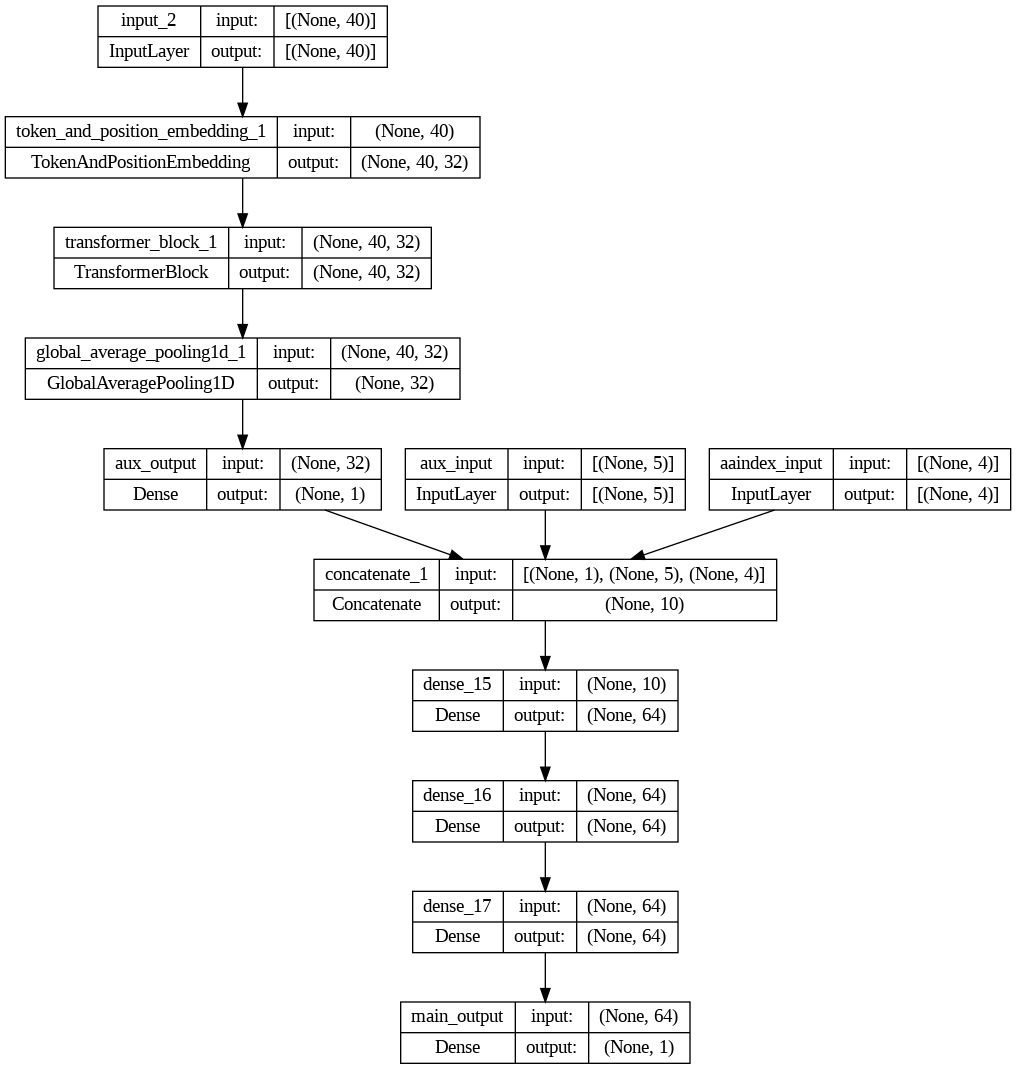

In [139]:
keras.utils.plot_model(model, "/content/drive/MyDrive/Colab Notebooks/peptide ml detection/final_figures/keras_model.png", show_shapes=True)

In [140]:
start_time = time.time()

history = model.fit([np.asanyarray(X_train_peptide), np.asanyarray(X_train_quant), np.asanyarray(X_train_aaindex1_corr)],
                    [np.asanyarray(y_train), np.asanyarray(y_train)],
                    validation_data = ([np.asarray(X_val_peptide), np.asanyarray(X_val_quant), np.asarray(X_val_aaindex1_corr)],
                                       [np.asarray(y_val), np.asarray(y_val)]),
                    epochs=150, batch_size=134, verbose=2)

print("")
print("Time taken for model to run: ", time.time() - start_time)

Epoch 1/150
15/15 - 9s - loss: 3.7761 - main_output_loss: 3.6223 - aux_output_loss: 0.7692 - main_output_accuracy: 0.4886 - aux_output_accuracy: 0.4736 - val_loss: 0.8728 - val_main_output_loss: 0.7336 - val_aux_output_loss: 0.6957 - val_main_output_accuracy: 0.6220 - val_aux_output_accuracy: 0.4970 - 9s/epoch - 572ms/step
Epoch 2/150
15/15 - 1s - loss: 1.0262 - main_output_loss: 0.8875 - aux_output_loss: 0.6933 - main_output_accuracy: 0.5254 - aux_output_accuracy: 0.5149 - val_loss: 0.7977 - val_main_output_loss: 0.6591 - val_aux_output_loss: 0.6931 - val_main_output_accuracy: 0.6086 - val_aux_output_accuracy: 0.5000 - 987ms/epoch - 66ms/step
Epoch 3/150
15/15 - 1s - loss: 0.8282 - main_output_loss: 0.6921 - aux_output_loss: 0.6801 - main_output_accuracy: 0.5532 - aux_output_accuracy: 0.5473 - val_loss: 0.8006 - val_main_output_loss: 0.6642 - val_aux_output_loss: 0.6819 - val_main_output_accuracy: 0.6027 - val_aux_output_accuracy: 0.5045 - 1s/epoch - 99ms/step
Epoch 4/150
15/15 - 1s -

In [141]:
history_dict = history.history
history_dict.keys()

# save to df
df_acc = pd.DataFrame({'Loss': history_dict['loss'],
                       'main_output_loss': history_dict['main_output_loss'],
                       'aux_output_loss': history_dict['aux_output_loss'],
                      'main_output_accuracy': history_dict['main_output_accuracy'],
                       'aux_output_accuracy': history_dict['aux_output_accuracy'],
                      'val_loss': history_dict['val_loss'],
                       'val_main_output_loss': history_dict['val_main_output_loss'],
                       'val_aux_output_loss': history_dict['val_aux_output_loss'],
                      'val_main_output_accuracy': history_dict['val_main_output_accuracy'],
                       'val_aux_output_accuracy': history_dict['val_aux_output_accuracy']})

In [142]:
df_acc_aaindex1 = pd.DataFrame({'raw_acc': history_dict['val_main_output_accuracy']})
df_acc_aaindex1['var_scaled'] = history_dict['val_main_output_accuracy']
df_acc_aaindex1['scaled'] = history_dict['val_main_output_accuracy']
df_acc_aaindex1['scaled_pca'] = history_dict['val_main_output_accuracy']
df_acc_aaindex1['raw_pca'] = history_dict['val_main_output_accuracy']
df_acc_aaindex1['corr_0.8'] = history_dict['val_main_output_accuracy']
df_acc_aaindex1['corr_0.5'] = history_dict['val_main_output_accuracy']
df_acc_aaindex1['corr_0.7'] = history_dict['val_main_output_accuracy']
df_acc_aaindex1['var_corr_0.6'] = history_dict['val_main_output_accuracy']
df_acc_aaindex1['var_corr_0.5'] = history_dict['val_main_output_accuracy']
df_acc_aaindex1

,raw_acc,var_scaled,scaled,scaled_pca,raw_pca,corr_0.8,corr_0.5,corr_0.7,var_corr_0.6,var_corr_0.5
0,0.622024,0.622024,0.622024,0.622024,0.622024,0.622024,0.622024,0.622024,0.622024,0.622024
1,0.608631,0.608631,0.608631,0.608631,0.608631,0.608631,0.608631,0.608631,0.608631,0.608631
2,0.602679,0.602679,0.602679,0.602679,0.602679,0.602679,0.602679,0.602679,0.602679,0.602679
3,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429
4,0.635417,0.635417,0.635417,0.635417,0.635417,0.635417,0.635417,0.635417,0.635417,0.635417
...,...,...,...,...,...,...,...,...,...,...
145,0.959821,0.959821,0.959821,0.959821,0.959821,0.959821,0.959821,0.959821,0.959821,0.959821
146,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357
147,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357
148,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357,0.955357


In [143]:
df_acc_aaindex1.to_csv('/content/drive/MyDrive/Colab Notebooks/peptide ml detection/final_data/M7_seq_aaindex1_all-val-scores_134batch_150epoch.tsv', sep='\t', index=False)

In [144]:
df_acc_aaindex1.describe(include='all')

,raw_acc,var_scaled,scaled,scaled_pca,raw_pca,corr_0.8,corr_0.5,corr_0.7,var_corr_0.6,var_corr_0.5
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.925089,0.925089,0.925089,0.925089,0.925089,0.925089,0.925089,0.925089,0.925089,0.925089
std,0.093655,0.093655,0.093655,0.093655,0.093655,0.093655,0.093655,0.093655,0.093655,0.093655
min,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429
25%,0.948661,0.948661,0.948661,0.948661,0.948661,0.948661,0.948661,0.948661,0.948661,0.948661
50%,0.958333,0.958333,0.958333,0.958333,0.958333,0.958333,0.958333,0.958333,0.958333,0.958333
75%,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286
max,0.971726,0.971726,0.971726,0.971726,0.971726,0.971726,0.971726,0.971726,0.971726,0.971726


In [145]:
df_acc.to_csv('/content/drive/MyDrive/Colab Notebooks/peptide ml detection/final_data/M8_seq_nsaf_aaindex1_var_corr05_REDO_train_134batch_150epoch.tsv', sep='\t', index=False)

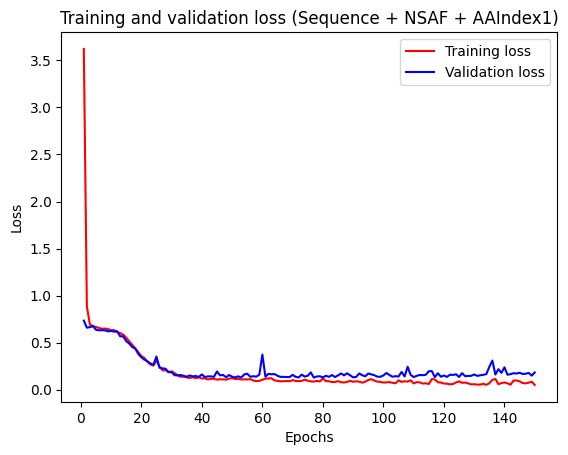

In [146]:
# plot training and validation loss
import matplotlib.pyplot as plt

train_loss = history_dict['main_output_loss']
val_loss = history_dict['val_main_output_loss']

acc = history_dict['main_output_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (Sequence + NSAF + AAIndex1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/peptide ml detection/final_figures/M8_seq_nsaf_aaindex1_var_corr05_REDO_train_val_loss_134b_150ep', dpi=200)
plt.show()

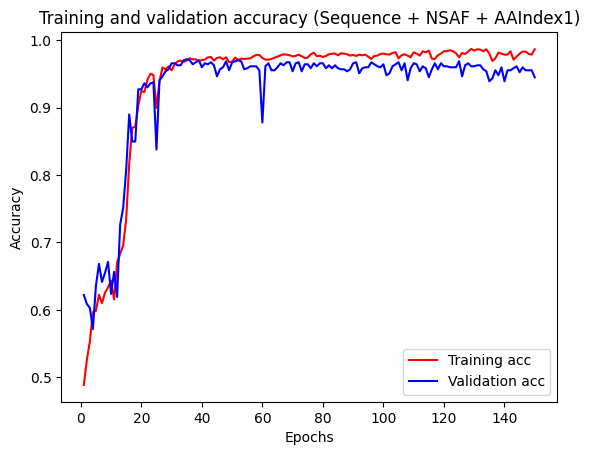

In [147]:
# plot training and validation accuracy
plt.clf()
train_acc = history_dict['main_output_accuracy']
val_acc = history_dict['val_main_output_accuracy']

plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (Sequence + NSAF + AAIndex1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/peptide ml detection/final_figures/M8_seq_nsaf_aaindex1_var_corr05_REDO_train_val_acc_134b_150ep', dpi=200)
plt.show()

In [148]:
df_acc_aaindex1 = pd.read_table('/content/drive/MyDrive/Colab Notebooks/peptide ml detection/final_data/M7_seq_aaindex1_all-val-scores_134batch_150epoch.tsv')
df_acc_nsaf_aaindex = pd.read_table('/content/drive/MyDrive/Colab Notebooks/peptide ml detection/final_data/M8_seq_nsaf_aaindex1_var_corr05_REDO_train_134batch_150epoch.tsv')

In [149]:
df_acc_nsaf_aaindex['val_main_output_accuracy']

0      0.622024
1      0.608631
2      0.602679
3      0.571429
4      0.635417
         ...   
145    0.959821
146    0.955357
147    0.955357
148    0.955357
149    0.944940
Name: val_main_output_accuracy, Length: 150, dtype: float64

## Saving model

In [150]:
history.model.save("/content/drive/MyDrive/Colab Notebooks/peptide ml detection/final_model/M8_seq_nsaf_aaindex1_var_corr05_REDO")

## Model evaluation

In [151]:
# train set
train_results = model.evaluate([np.asarray(X_train_peptide), np.asanyarray(X_train_quant), np.asanyarray(X_train_aaindex1_corr)],
                               [np.asarray(y_train), np.asarray(y_train)])

print("%s: %.2f%%" % (model.metrics_names[1], train_results[1]*100))
print("%s: %.2f%%" % (model.metrics_names[3], train_results[3]*100))

63/63 [==============================] - 0s 5ms/step - loss: 0.0568 - main_output_loss: 0.0425 - aux_output_loss: 0.0714 - main_output_accuracy: 0.9900 - aux_output_accuracy: 0.9881
main_output_loss: 4.25%
main_output_accuracy: 99.00%


In [152]:
# validation set
val_results = model.evaluate([np.asarray(X_val_peptide), np.asanyarray(X_val_quant), np.asanyarray(X_val_aaindex1_corr)],
                             [np.asarray(y_val), np.asarray(y_val)])

print("%s: %.2f%%" % (model.metrics_names[1], val_results[1]*100))
print("%s: %.2f%%" % (model.metrics_names[3], val_results[3]*100))

21/21 [==============================] - 0s 6ms/step - loss: 0.2118 - main_output_loss: 0.1833 - aux_output_loss: 0.1422 - main_output_accuracy: 0.9449 - aux_output_accuracy: 0.9449
main_output_loss: 18.33%
main_output_accuracy: 94.49%


In [153]:
# test set
test_results = model.evaluate([np.asarray(X_test_peptide), np.asanyarray(X_test_quant), np.asanyarray(X_test_aaindex1_corr)],
                              [np.asarray(y_test), np.asarray(y_test)])

print("%s: %.2f%%" % (model.metrics_names[1], test_results[1]*100))
print("%s: %.2f%%" % (model.metrics_names[3], test_results[3]*100))

36/36 [==============================] - 0s 5ms/step - loss: 0.1511 - main_output_loss: 0.1264 - aux_output_loss: 0.1237 - main_output_accuracy: 0.9713 - aux_output_accuracy: 0.9661
main_output_loss: 12.64%
main_output_accuracy: 97.13%


## Model prediction

In [154]:
df = pd.DataFrame({'Peptide': X_test['Peptide'], 'Detectability': y_test})
df.shape

(1150, 2)

In [155]:
test_predictions = model.predict([np.array([
    convertPeptide(pep, maxLength) for pep in df['Peptide']]),
                                  np.array(X_test_quant), np.array(X_test_aaindex1_corr)], verbose=1)

36/36 [==============================] - 1s 5ms/step


In [156]:
df["Predictions"] = test_predictions[0].flatten()
df.head()

,Peptide,Detectability,Predictions
0,MLPVDEFLPVMFDK,0,0.000777
1,NEIQDLQTKMR,1,0.992487
2,VPTHPEGK,0,0.001915
3,LLDDIKMLNK,1,0.984428
4,EEEDDVDLELR,0,0.001787


In [157]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/peptide ml detection/final_data/M8_PRED_seq_nsaf_aaindex1_var_corr_REDO_134b_150ep.tsv', sep='\t', index=False)

In [158]:
df = pd.read_table('/content/drive/MyDrive/Colab Notebooks/peptide ml detection/final_data/M8_PRED_seq_nsaf_aaindex1_var_corr_REDO_134b_150ep.tsv')

In [159]:
# visualise prediction distribution
import seaborn as sns

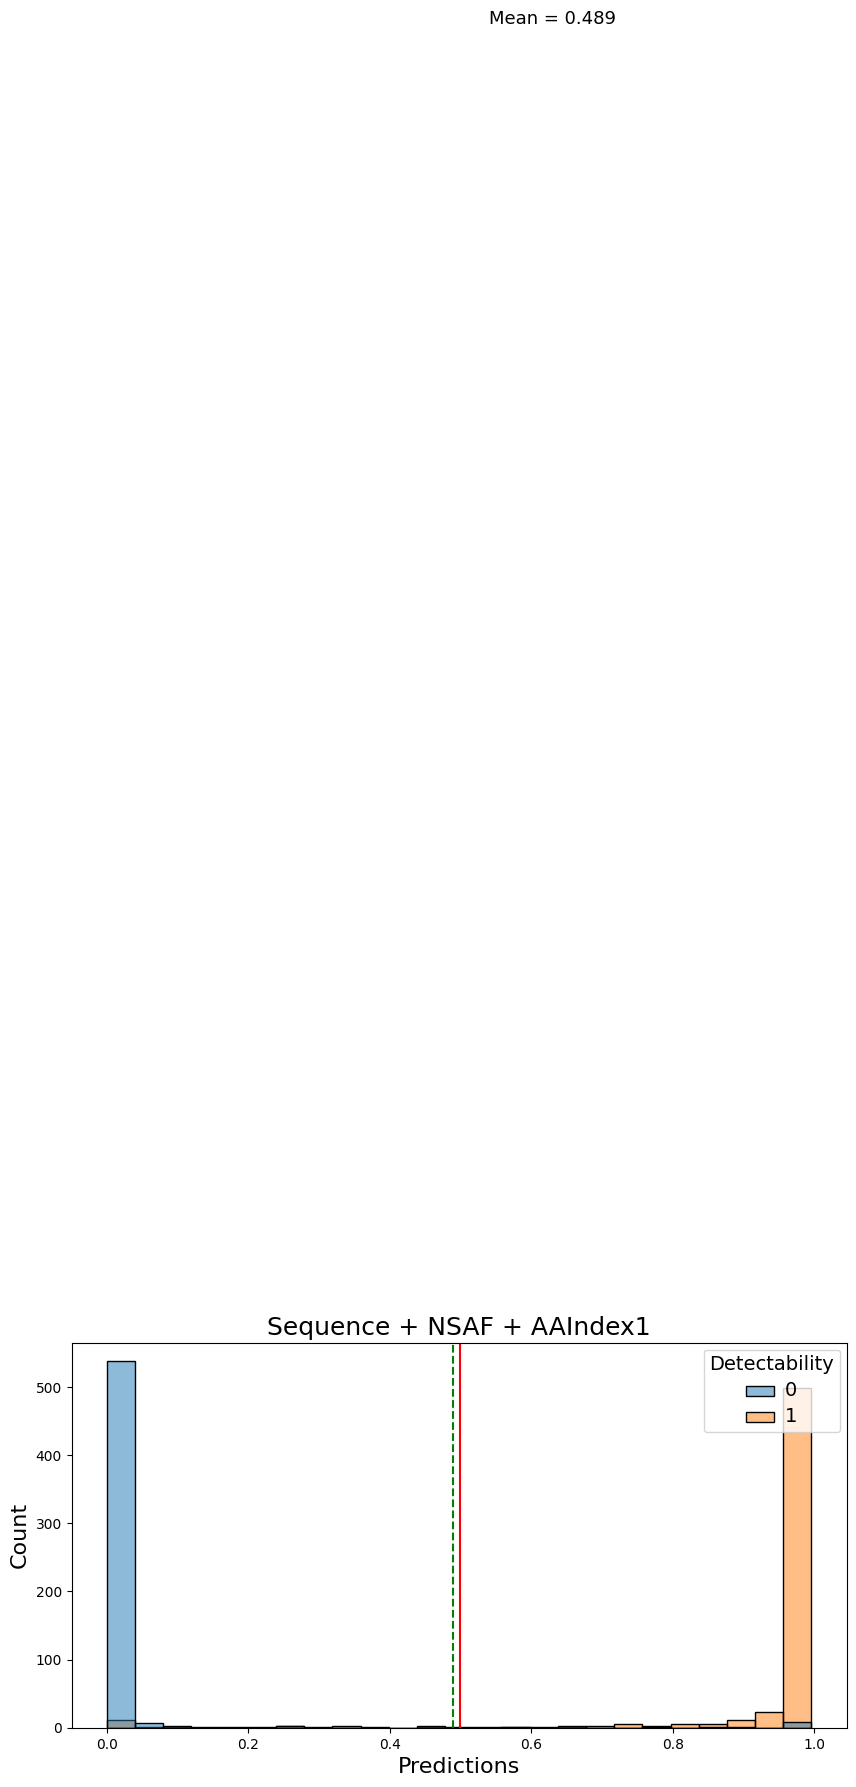

In [160]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x=df['Predictions'], hue=df['Detectability'], stat='count', bins=25)
ax.set_title('Sequence + NSAF + AAIndex1', fontsize=18)

ax.set_xlabel('Predictions', fontsize=16)
ax.set_ylabel('Count', fontsize=16)

plt.axvline(x=df['Detectability'].mean(), color='r')
plt.axvline(x=df['Predictions'].mean(), color='g', ls='--')
plt.text(0.54,2500, ('Mean = {:.3f}'.format(df['Predictions'].mean())), fontsize=13)

plt.setp(ax.get_legend().get_texts(), fontsize=14)
plt.setp(ax.get_legend().get_title(), fontsize=14)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/peptide ml detection/final_figures/M8_hist_seq_nsaf_aaindex1_FS.png', dpi=200)

In [161]:
# confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(df['Predictions']))
confusion_matrix

array([[559,  16],
       [ 17, 558]])

In [162]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, np.rint(df['Predictions']))

0.971304347826087

In [163]:
# Recall
from sklearn.metrics import recall_score
recall_score(y_test, round(df['Predictions']), average='binary')

0.9704347826086956

In [164]:
# Precision
from sklearn.metrics import precision_score
precision_score(y_test, np.rint(df['Predictions']), average='binary')

0.9721254355400697

In [165]:
# F1 score
from sklearn.metrics import f1_score
f1_score(y_test, np.rint(df['Predictions']), average='binary')

0.9712793733681462

In [166]:
# MCC (Matthew's correlation coefficient)
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, np.rint(df['Predictions']))

0.9426101211505994